<a href="https://colab.research.google.com/github/nickzherdev/DroneLight/blob/master/DroneLight_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make a drone Light-Paint the word $^1$ you just draw in the air with your hand $^2$

### $^1$ let the Classificator decide how bad is your handwriting :)
### $^2$ wearing a glove with built-in Accelrometer

Project for course "Introduction to Data Science" @ Skoltech

#### Nikolay Zherdev, Roman Ibrahimov 

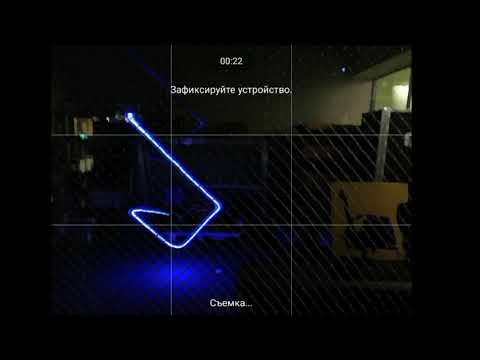

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("IJmxCpXhA4Y")

###  IMU Data Reading

In  our  project,  the  user wears the glove and performs one of four gesture patterns. We  use  the  Arduino Nano, IMU sensor MPU-6050 and flex sensor,  shown  in  Figure 2 , as our data input source.  

When flex sensor bends more than some threshold - data recording starts, when flex sensor is relaxed - data recording stops. To prevent drift of IMU readings we perform automatic reset before each new recording.

IMU provides us with 3 degree of freedom sensor readings
    - accelerometers 
Inputs  from  IMU  are  streaming  to  local  PC through Arduino which is connected by USB

### Training Data Collection

For each of the letters [S, k, o, l, j] we collect 25 sets of data samples manually. Each data sample is a sequence of 
    - raw IMU sensor readings (3 features)
that has a pre-defined start and ending time. We also include a label describing the gesture pattern for each data sample. 

For the first iteration of the project, the proposed algorithm should map 5 input gestures to 5 letters, which correspond to 5 sets of flight setpoints.

### Data Pre-Processing and Feature Extraction

- normalize the accelerometer inputs
- process all our input sequences to be the same length by sampling within the start-end window
-  each of our input data sample is a sequence of 30 dimensional feature arrays representing the status of the glove at a specific time step

### The Drone part

these setpoints need to be sent to drone to follow this path

with numpy (x, y z) array make a drone to fly through these setponts (Roman)

control LED while flying

record the drone flight

Input: recorded gestures / path from glove with IMU

Output: drone light-painting the letter / word


# Let's begin

#### Import libs

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import seaborn as sns
from scipy import signal

sns.set()
%matplotlib inline

# ignore FutureWarning from sklearn
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# display pandas results to 3 decimal points, not in scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Read an example of the data

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

# ! ls /content

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_csv('s_1.csv')
data.columns = ['Acc_x', 'Acc_y', 'Acc_z']
data.head()

,Acc_x,Acc_y,Acc_z
0,-4708,2692,15224
1,-3532,3284,15728
2,-4984,668,15084
3,-7112,-628,14128
4,-4376,-908,13808


In [0]:
data.shape

(82, 3)

#### Draw raw data

No handles with labels found to put in legend.


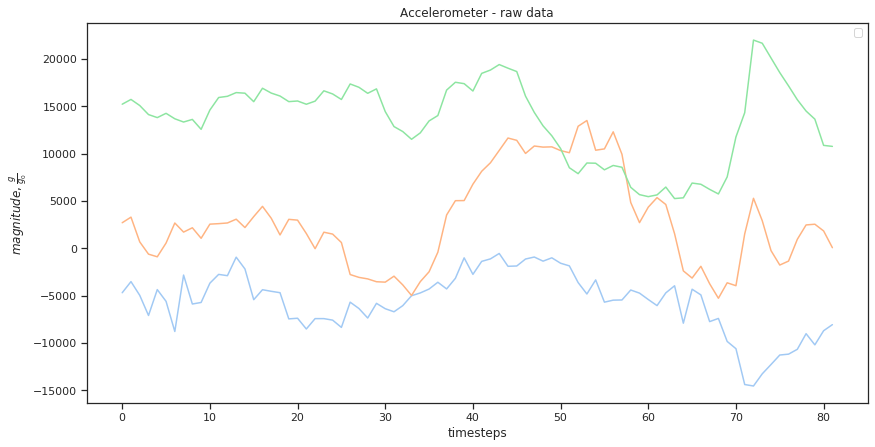

In [0]:
sns.set(style="ticks", palette="pastel", rc={'figure.figsize':(14,7)})

for column in data.columns:
  plt.plot(data[column])
  
plt.legend(loc='best')
plt.ylabel(r'$magnitude, \frac{g}{g_0}$')
plt.xlabel('timesteps')
plt.title('Accelerometer - raw data')
plt.show()

#### Draw smoothed data

No handles with labels found to put in legend.


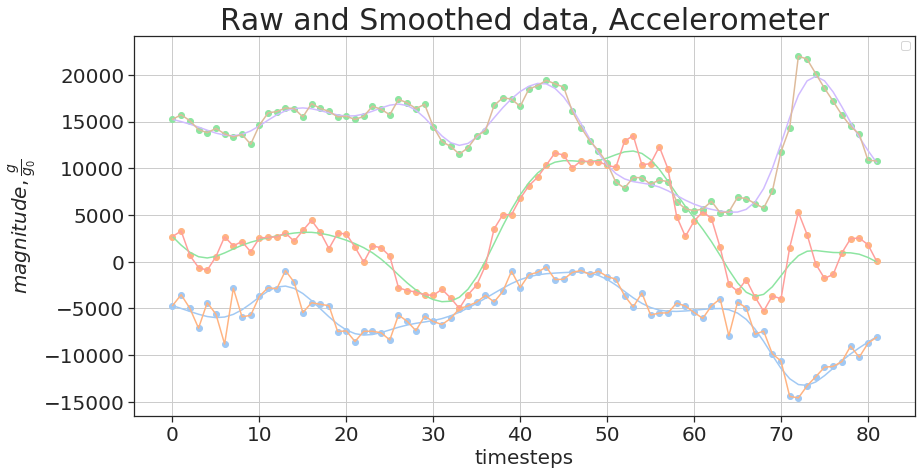

In [0]:
for i, val in enumerate(data.columns):
  plt.plot(signal.filtfilt(*signal.butter(3, 0.2), data.iloc[:, i]))
  plt.plot(data.iloc[:, i])
  plt.scatter(range(len(data.iloc[:, i])), data.iloc[:, i])

plt.ylabel(r'$magnitude, \frac{g}{g_0}$', fontsize="20")
plt.xlabel('timesteps', fontsize="20")
plt.title("Raw and Smoothed data, Accelerometer", fontsize="30")
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.grid()
plt.savefig('raw_smoothed.png')
plt.legend(loc='best');

#### Filter data and make each sequence the same length

Filter the accellerometers signal using a low pass filter. This removes any noise that is not caused by slow moving arm.

In [0]:
def discretize_data(data, samples):
    # width = round(len(data) / samples)
    width = int(len(data) / samples)

    # print('width =', width)
    output = [np.mean(data[i*width : (i+1)*width]) for i in range(samples)]
    return output

def smooth_data(X, a, b):
  return signal.filtfilt(*signal.butter(a, b), X)

#### Draw equalized filtered data

No handles with labels found to put in legend.


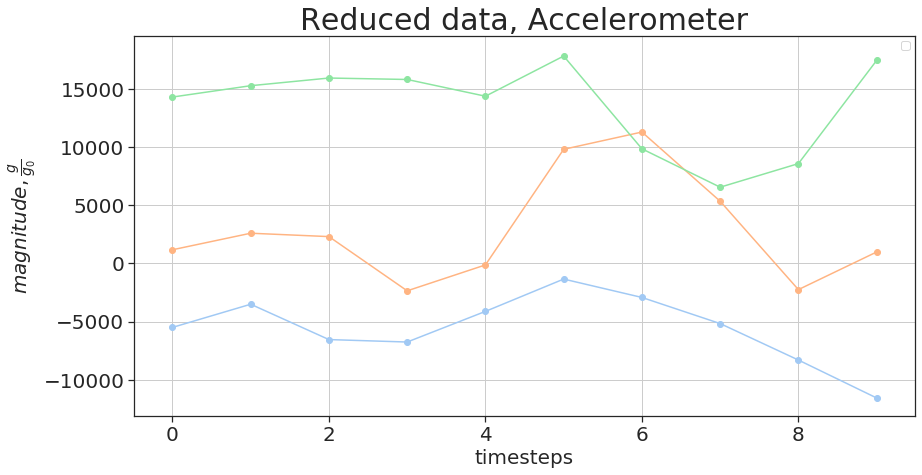

In [0]:
df_sample = pd.DataFrame()

for column in data.columns:
  smooth = smooth_data(data[column], 3, 0.2)
  discrete = discretize_data(smooth, 10)
  df_sample[column] = discrete
  plt.plot(df_sample[column])
  plt.scatter(range(len(df_sample[column])), df_sample[column])

plt.ylabel(r'$magnitude, \frac{g}{g_0}$', fontsize="20")
plt.xlabel('timesteps', fontsize="20")
plt.title("Reduced data, Accelerometer", fontsize="30")
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.grid()
plt.savefig('reduced_acc.png')
plt.legend(loc='best');

#### Create array of features (for each gesture we have separate csv file)

In [0]:
import glob

files = glob.glob('/content/drive/My Drive/Colab/data_set_o/*.csv')
# print(files)
# for file in files:
#   print(file)

In [0]:
dataset = pd.DataFrame()

if not(files):
    print("empty list") 
else:
    for i, val in enumerate(files):
        data = pd.read_csv(val)
        # print(data.shape)
        data.columns = ['Acc_x', 'Acc_y', 'Acc_z']

        # print(i, val[39])
        letter = pd.Series(val[41], index=['letter'])

        # data.drop(data.tail(10).index, inplace=True) # drop last n rows

        df = pd.DataFrame()
        for column in data.columns:
            smooth = smooth_data(data[column], 3, 0.2)
            discrete = discretize_data(smooth, 10)
            df[column] = discrete

        gesture = pd.concat([df["Acc_x"], df["Acc_y"], df["Acc_z"]], ignore_index=True)
        # gesture = pd.concat([data["Acc_x"], data["Acc_y"], data["Acc_z"]], ignore_index=True)

        gesture = pd.concat([letter, gesture])  #   df["Acc_x"]
        dataset = dataset.append(gesture, ignore_index=True)

    # dataset.set_index('letter', inplace=True)

dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,letter
0,-6539.304,-1026.194,-16589.694,-24204.029,-15231.844,-13996.867,-10118.274,-8318.223,-8735.458,-10064.468,119.655,548.024,-2460.245,-1148.510,154.750,-9445.235,-12051.568,6170.716,4767.644,4094.385,-4521.206,3763.230,15678.505,13889.094,9982.730,10179.547,7208.808,10354.297,9952.379,11570.418,J
1,-9870.564,-1586.081,-14083.536,-18597.805,-9997.180,-10541.661,-8284.743,-8510.105,-8714.861,-7959.376,-76.771,1376.796,4725.818,1442.619,83.092,-6056.514,-2345.503,5836.957,4159.005,2708.693,-4699.901,3310.640,15948.463,17848.203,12429.384,15570.466,10164.546,10525.738,11573.872,13155.662,J
2,-3179.020,-4664.605,-8227.265,-4216.924,-5984.777,-2461.735,-3192.062,-4399.677,-5269.889,-14662.273,2067.979,3412.360,2416.750,-2160.656,1873.358,9004.074,12009.511,5024.128,-5642.877,-9793.050,16390.748,15039.495,17288.510,12324.211,18489.136,20961.832,10436.269,-1574.367,3247.083,18820.442,s
3,-9654.909,-9855.036,-5422.264,-1348.432,-3114.672,-4222.298,-5949.287,-11618.924,-11251.469,-5016.994,-1454.561,3160.685,8358.840,12842.457,10331.184,1697.602,-8188.192,-7370.237,-815.446,3400.225,13434.937,15074.468,18430.073,13365.770,4942.917,-2477.991,2880.934,18065.581,20472.175,14120.244,O
4,-1529.639,-2196.936,-4182.307,-4083.758,-5179.412,-3325.623,-3231.125,-6505.947,-8031.650,-11221.772,2441.465,1375.387,-1060.584,-1664.991,1369.845,2927.206,6639.003,2318.481,-5301.815,-6961.653,15767.224,17514.244,18769.183,13270.408,14717.328,25646.732,8965.036,-2560.448,5720.834,22118.116,s


In [0]:
y = dataset.iloc[:, -1]
y.head()

0    J
1    J
2    s
3    O
4    s
Name: letter, dtype: object

In [0]:
X = dataset.iloc[:, 0:-1]
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,-6539.304,-1026.194,-16589.694,-24204.029,-15231.844,-13996.867,-10118.274,-8318.223,-8735.458,-10064.468,119.655,548.024,-2460.245,-1148.510,154.750,-9445.235,-12051.568,6170.716,4767.644,4094.385,-4521.206,3763.230,15678.505,13889.094,9982.730,10179.547,7208.808,10354.297,9952.379,11570.418
1,-9870.564,-1586.081,-14083.536,-18597.805,-9997.180,-10541.661,-8284.743,-8510.105,-8714.861,-7959.376,-76.771,1376.796,4725.818,1442.619,83.092,-6056.514,-2345.503,5836.957,4159.005,2708.693,-4699.901,3310.640,15948.463,17848.203,12429.384,15570.466,10164.546,10525.738,11573.872,13155.662
2,-3179.020,-4664.605,-8227.265,-4216.924,-5984.777,-2461.735,-3192.062,-4399.677,-5269.889,-14662.273,2067.979,3412.360,2416.750,-2160.656,1873.358,9004.074,12009.511,5024.128,-5642.877,-9793.050,16390.748,15039.495,17288.510,12324.211,18489.136,20961.832,10436.269,-1574.367,3247.083,18820.442
3,-9654.909,-9855.036,-5422.264,-1348.432,-3114.672,-4222.298,-5949.287,-11618.924,-11251.469,-5016.994,-1454.561,3160.685,8358.840,12842.457,10331.184,1697.602,-8188.192,-7370.237,-815.446,3400.225,13434.937,15074.468,18430.073,13365.770,4942.917,-2477.991,2880.934,18065.581,20472.175,14120.244
4,-1529.639,-2196.936,-4182.307,-4083.758,-5179.412,-3325.623,-3231.125,-6505.947,-8031.650,-11221.772,2441.465,1375.387,-1060.584,-1664.991,1369.845,2927.206,6639.003,2318.481,-5301.815,-6961.653,15767.224,17514.244,18769.183,13270.408,14717.328,25646.732,8965.036,-2560.448,5720.834,22118.116


#### Get train, validating and testing sets

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=24)

In [0]:
y_test.shape

(50,)

In [0]:
y_train.shape

(75,)

#### Check ranges of the data

In [0]:
# X.max(0) - X.min(0)

#### Choose metrics

In [0]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score


def evaluate_model(model, X, y, x_test, y_test, cv, scoring='accuracy'):
    """
    Reports perfomance of the model on given set of data (test / train)

    model - sklearn regression model (trained)

    X  - array,
     (n_observations_train, n_features) matrix,
     train data.
     
    y - array,
     (n_observation_train, ) array of train target

    """

    y_pred = model.predict(x_test)
    # scores = cross_val_score(lr, X_train_scaled, y_train, scoring="accuracy", cv=cv)
    # y_pred_cv = cross_val_predict(lr, X_test_scaled, y_test, cv=cv)
    # print('KFold cross_val_score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

    with np.printoptions(precision=3, suppress=True):
        print('Accuracy on test set is {}'.format(accuracy_score(y_test, y_pred)))
        print('Precision on test set is {}'.format(precision_score(y_test, y_pred, average='weighted')))
        print('Recall on test set is {}'.format(recall_score(y_test, y_pred, average='weighted')))

    print("Prediction for test set:")
    print(y_pred)

    print(" ")
    print("model.best_score_", model.best_score_)
    # print('roc auc', roc_auc_score(y_test, y_predict_proba))
    print("model.best_params_", model.best_params_)
    print(" ")
    return y_pred

#### Scale data

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train.astype(np.float))
X_test_scaled = scaler.transform(X_test.astype(np.float))

# with np.printoptions(precision=3, suppress=True):
#     print(X_train_scaled)

# with np.printoptions(precision=3, suppress=True):
#     print(scaler.transform(X_test_scaled))

In [0]:
X_test_scaled.shape

(50, 30)

#### Split data using StratifiedKFold

In [0]:
from sklearn.model_selection import StratifiedKFold

stratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True)
cv = stratifiedKFold.split(X_train_scaled, y_train)

#### Try Nearest-Neighbor Classifier (don't forget to normalize data)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

gs_knn = GridSearchCV(knn, param_grid={"n_neighbors":list(range(1, 11))}, cv=cv)
gs_knn.fit(X_train_scaled, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### RESULTS: Nearest-Neighbor Classifier

In [0]:
y_pred = evaluate_model(gs_knn, X_train_scaled, y, X_test_scaled, y_test, cv)

Accuracy on test set is 0.98
Precision on test set is 0.9818181818181819
Recall on test set is 0.98
Prediction for test set:
['O' 'k' 'L' 'k' 's' 's' 'J' 's' 'k' 'J' 'k' 'O' 'k' 's' 's' 'k' 'L' 's'
 'L' 'L' 'L' 'k' 'J' 'L' 'J' 'L' 'J' 'O' 's' 'L' 'O' 'O' 'k' 'k' 'O' 'L'
 'L' 'L' 'J' 's' 's' 's' 'k' 'J' 's' 'O' 'O' 'k' 'J' 'O']
 
model.best_score_ 1.0
model.best_params_ {'n_neighbors': 1}
 


In [0]:
print(confusion_matrix(y_test, y_pred))

[[ 8  0  0  0  1]
 [ 0 11  0  0  0]
 [ 0  0  9  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 10]]


#### Write a function for pretty confusion matrix

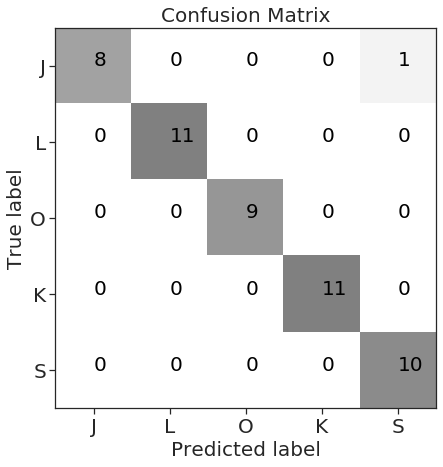

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.colors


def plot_confusion_matrix(y_test,model_test):
    cm = confusion_matrix(y_test, model_test)
    plt.figure(1)
    plt.clf()
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","gray"])
    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # plt.cm.Wistia
    classNames = ['J', 'L', 'O', 'K', 'S']
    plt.title('Confusion Matrix', fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    tick_marks = np.arange(len(classNames))
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    # s = [['TN','FP'], ['FN', 'TP']]
    for i in range(5):
        for j in range(5):
            plt.text(j,i, str(cm[i][j]), size=20, color='black')
    plt.savefig('confusion_matrix.png')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

In [0]:
y_predict_proba = gs_knn.predict_proba(X_test_scaled)
with np.printoptions(precision=3, suppress=True):
    print(" ")
    print("y_predict_proba")
    print(y_predict_proba)

 
y_predict_proba
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


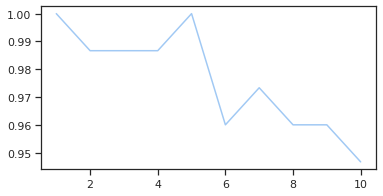

In [0]:
params = [x['n_neighbors'] for x in gs_knn.cv_results_['params']]
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.plot(params, gs_knn.cv_results_['mean_test_score'])

#### Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import Normalizer

gs_rfc = GridSearchCV(RandomForestClassifier(), 
                   {'n_estimators':[50, 100, 200], 
                    'max_depth':[2, 3, 4]
                   },
                   scoring='accuracy', cv=5)
gs_rfc.fit(X_train_scaled, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### RESULTS: Random forest

In [0]:
y_pred = evaluate_model(gs_rfc, X_train_scaled, y, X_test_scaled, y_test, cv)

Accuracy on test set is 0.98
Precision on test set is 0.9816666666666666
Recall on test set is 0.98
Prediction for test set:
['O' 'k' 'L' 'k' 's' 's' 'J' 's' 'k' 'J' 'k' 'O' 'k' 's' 's' 'k' 'L' 's'
 'L' 'L' 'L' 'k' 'J' 'L' 'J' 'L' 'J' 'O' 's' 'L' 'O' 'O' 'k' 'k' 'O' 'L'
 'L' 'L' 'J' 's' 's' 'k' 'k' 'J' 's' 'O' 'O' 'k' 'J' 'O']
 
model.best_score_ 0.9733333333333334
model.best_params_ {'max_depth': 3, 'n_estimators': 100}
 


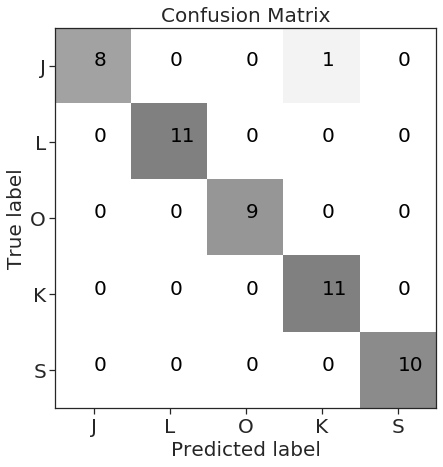

In [0]:
plot_confusion_matrix(y_test, y_pred)

In [0]:
y_predict_proba = gs_rfc.predict_proba(X_test_scaled)
with np.printoptions(precision=3, suppress=True):
    print(" ")
    print("y_predict_proba")
    print(y_predict_proba)

 
y_predict_proba
[[0.074 0.073 0.517 0.263 0.073]
 [0.082 0.085 0.029 0.738 0.066]
 [0.127 0.77  0.01  0.046 0.048]
 [0.017 0.048 0.02  0.878 0.037]
 [0.012 0.031 0.033 0.036 0.889]
 [0.011 0.026 0.03  0.062 0.871]
 [0.799 0.144 0.017 0.038 0.002]
 [0.053 0.128 0.054 0.03  0.736]
 [0.036 0.053 0.028 0.839 0.044]
 [0.901 0.077 0.007 0.013 0.002]
 [0.093 0.072 0.031 0.695 0.109]
 [0.102 0.048 0.505 0.271 0.074]
 [0.051 0.03  0.04  0.745 0.135]
 [0.016 0.035 0.014 0.063 0.872]
 [0.009 0.082 0.03  0.132 0.747]
 [0.036 0.048 0.108 0.699 0.109]
 [0.129 0.744 0.02  0.06  0.048]
 [0.002 0.042 0.084 0.07  0.801]
 [0.118 0.807 0.009 0.037 0.029]
 [0.096 0.572 0.177 0.012 0.143]
 [0.102 0.777 0.009 0.043 0.068]
 [0.045 0.066 0.031 0.803 0.055]
 [0.606 0.314 0.022 0.054 0.005]
 [0.058 0.704 0.159 0.039 0.041]
 [0.823 0.098 0.026 0.031 0.022]
 [0.253 0.673 0.007 0.047 0.019]
 [0.751 0.147 0.03  0.021 0.05 ]
 [0.012 0.019 0.937 0.025 0.007]
 [0.028 0.076 0.03  0.082 0.783]
 [0.084 0.77  0.029 0.044

## Resources

- Real-time Gesture Pattern Classification with IMU Data. 
Alex Fu, Yangyang Yu
http://stanford.edu/class/ee267/Spring2017/report_fu_yu.pdf

- lib for training with IMU

- Attitude Estimation - Data and Code Listings
http://philsal.co.uk/projects/imu-attitude-estimation

https://github.com/pms67/Attitude-Estimation

- Micropython ESP32 board
https://medium.com/@nihal.pasham/micropython-just-works-4e8979e7d7a6

https://github.com/nihalpasham/micropython_sensorfusion

- Smartphone-Based Recognition of Human Activities and Postural Transitions Data Set
https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions

https://beckernick.github.io/activity-prediction/

- Sensor Fusion on Android Devices: A Revolution in Motion Processing
https://www.youtube.com/watch?v=C7JQ7Rpwn2k

- An introduction to inertial navigation
https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-696.pdf

- Implementing Positioning Algorithms Using Accelerometers
https://www.nxp.com/docs/en/application-note/AN3397.pdf

- Madgwick
https://x-io.co.uk/open-source-imu-and-ahrs-algorithms/